## asdf

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
# set results directory
results_dir = Path(cfg.results_dirs['mutation'], 'dosage_effects')

In [3]:
# process all component experiments
# control, drop_target, only_target
# TODO: explain
results_df = []
for subdir in results_dir.iterdir():
    experiment = subdir.stem
    gene_dir = Path(subdir, 'gene')
    model_results_df = au.load_stratified_prediction_results(gene_dir, 'gene')
    model_results_df['experiment'] = experiment
    results_df.append(model_results_df)
    
results_df = pd.concat(results_df)
print(results_df.shape)
results_df.head()

(2160, 9)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.75778,0.74085,TP53,expression,shuffled,42,train,0,drop_target
1,0.73380,0.71366,TP53,expression,shuffled,42,test,0,drop_target
2,0.61896,0.58021,TP53,expression,shuffled,42,cv,0,drop_target
3,0.74560,0.72257,TP53,expression,shuffled,42,train,1,drop_target
4,0.71528,0.68853,TP53,expression,shuffled,42,test,1,drop_target


<AxesSubplot:xlabel='identifier', ylabel='aupr'>

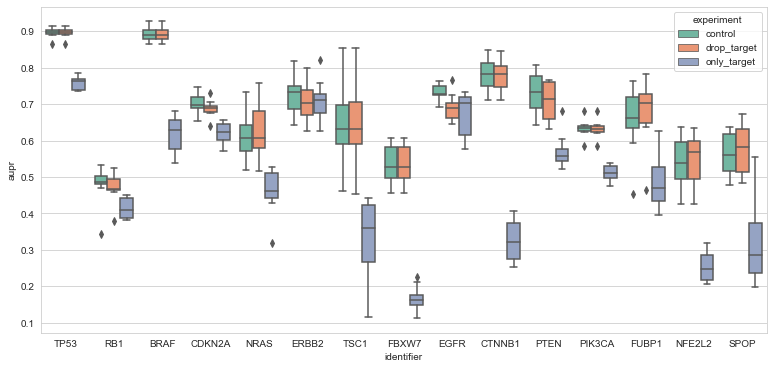

In [4]:
# try plot with no normalization/correction for shuffled baseline
sns.set({'figure.figsize': (13, 6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

plot_df = results_df[((results_df.signal == 'signal') &
                      (results_df.data_type == 'test'))]
hue_order = [
    'control',
    'drop_target',
    'only_target'
]
sns.boxplot(data=plot_df, x='identifier', y='aupr', hue='experiment',
            hue_order=hue_order)

In [5]:
# now correct for shuffled baseline
results_df = (results_df
    .drop(columns='training_data')
    .rename(columns={'experiment': 'training_data'})
)
all_results_df = au.compare_all_data_types(results_df,
                                           0.05,
                                           filter_genes=False,
                                           compare_ind=True)
all_results_df = all_results_df.rename(columns={'training_data': 'experiment'})
all_results_df.head()

,gene,seed,fold,delta_aupr,experiment
0,BRAF,1,0,0.34253,drop_target
1,BRAF,1,1,0.27114,drop_target
2,BRAF,1,2,0.27199,drop_target
3,BRAF,1,3,0.36277,drop_target
4,BRAF,42,0,0.29706,drop_target


<AxesSubplot:xlabel='gene', ylabel='delta_aupr'>

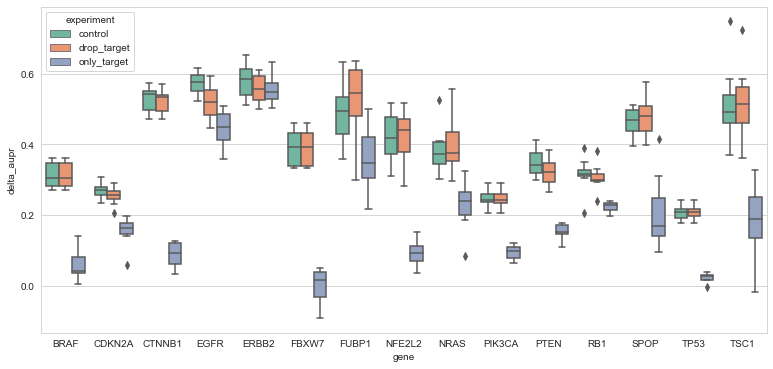

In [6]:
sns.set({'figure.figsize': (13, 6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

hue_order = [
    'control',
    'drop_target',
    'only_target'
]
sns.boxplot(data=all_results_df, x='gene', y='delta_aupr', hue='experiment',
            hue_order=hue_order)

In [7]:
pivot_df = all_results_df.pivot(index=['gene', 'seed', 'fold'],
                                columns='experiment',
                                values='delta_aupr')
pivot_df.head()

experiment      control  drop_target  only_target
gene seed fold                                   
BRAF 1    0     0.34253      0.34253      0.07584
          1     0.27114      0.27114      0.09841
          2     0.27199      0.27199      0.03799
          3     0.36277      0.36277      0.00689
     42   0     0.29706      0.29706      0.04475

In [8]:
pivot_df['drop_target'] = pivot_df.control - pivot_df.drop_target
pivot_df['only_target'] = pivot_df.control - pivot_df.only_target

pivot_df = (pivot_df
  .drop(columns='control')
  .reset_index()
  .melt(id_vars=['gene', 'seed', 'fold'],
        value_vars=['drop_target', 'only_target'],
        value_name='delta_aupr')
)

pivot_df.head()

,gene,seed,fold,experiment,delta_aupr
0,BRAF,1,0,drop_target,0.0
1,BRAF,1,1,drop_target,0.0
2,BRAF,1,2,drop_target,0.0
3,BRAF,1,3,drop_target,0.0
4,BRAF,42,0,drop_target,0.0


<AxesSubplot:xlabel='gene', ylabel='delta_aupr'>

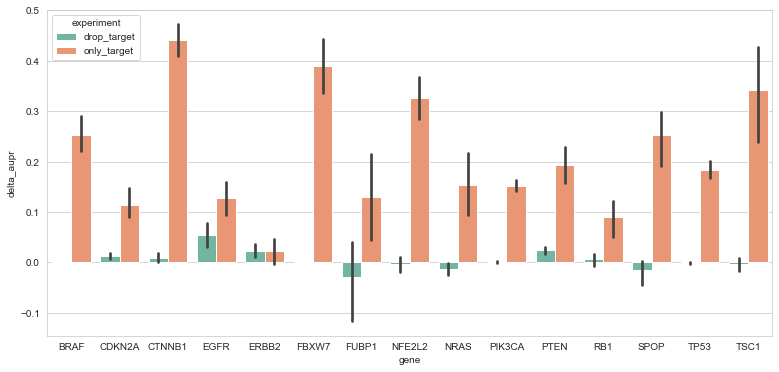

In [9]:
sns.set({'figure.figsize': (13, 6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

hue_order = [
    'drop_target',
    'only_target'
]
sns.barplot(data=pivot_df, x='gene', y='delta_aupr', hue='experiment',
            hue_order=hue_order)